<a href="https://colab.research.google.com/github/soheil91/urbandigitaltwin.github.io/blob/main/Poisson_DES_Airport_Passenger_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Poisson Process**


### 🧠 Concept of Poisson Process

A **Poisson process** is a mathematical model used to describe **random events that happen over time** (in this case, passengers arriving at different times). The key idea is that the **arrival events (passengers)** are **independent** of each other and happen at a constant average rate, but randomly.

*   **A Poisson process with rate `λ` means:**

    Implementation: `np.random.poisson(POISSON_MEAN_PASSENGERS)`
    
    The number of arrivals over a time period T follows a Poisson distribution.


*   **The time between arrivals follows an exponential distribution with mean `1/λ`**

    Implementation: `generate_passenger_arrivals(self)`
    
    To simulate n arrivals in a fixed window:

    Generate n-1 exponentially distributed inter-arrival times.

    Add them up cumulatively to get arrival timestamps.

    Normalize this to fit within the fixed window (in our case: 3600 seconds = 1 hour).

\

In our simulation, **passenger arrivals** for each flight are modeled using a **Poisson process**.

*   The **Poisson distribution** is used to model the **number of events** that occur in a fixed interval of time, given a certain **average rate of occurrence (λ)**.

    Models **how many passengers** arrive at the gate in a specific time interval.

    Ref: [Poisson Distribution | StatsDirect](https://www.statsdirect.com/help/distributions/poisson.htm)

*   The **Exponential distribution** models the **time between events** (or inter-arrival times) in a Poisson process.

    Models the **waiting times between passenger arrivals**.

    Ref: [Exponential Distribution | Newcastle University ](https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/business/probability/exponential-distribution.html)

    Ref: [Exponential Distribution | Six Sigma Study Guide](https://sixsigmastudyguide.com/exponential-distribution/)

### 👀 Example of Passenger Arrival Process

*    Suppose the flight departure time is 12:00 PM.
*    We want passengers to arrive between 9:00 AM and 10:00 AM.
*    We expect 5 passengers per hour (so, λ = 5).

\
**Step 1:** Determine the number of passengers for the flight.
You would use a Poisson distribution to get the number of passengers arriving in the 1-hour window (between 9:00 AM and 10:00 AM).
> num_passengers = np.random.poisson(lam=5, size=1)[0]

*    For example, the result might be num_passengers = 4.

\
**Step 2:** Determine the arrival times of the passengers.
For each passenger, you generate the inter-arrival times (time between arrivals) using Exponential distribution. These inter-arrival times will give you the exact arrival times of each passenger.
> inter_arrival_times = np.random.exponential(scale=1/5, size=num_passengers - 1)
> arrival_times = np.cumsum(np.insert(inter_arrival_times, 0, 0))

\
**Step 3:** Normalize the arrival times.
After generating the inter-arrival times and calculating the arrival times, you normalize these times to fit within the desired window (e.g., between 9:00 AM and 10:00 AM).


## **Import Libraries**

In [ ]:
!pip install simpy
!pip install pandas
import simpy
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from dataclasses import dataclass
from typing import Dict, Any

## **Parameter Tuning**

In [ ]:
# Simulation parameters
SIM_TIME = 30 * 24 * 60 * 60  # day(s), hour(s), minute(s), second(s)
FLIGHT_RATE = 5 / 3600  # 5 flights per hour (on average)

# Flight parameters
BOARDING_DURATION = [45 * 60, 60 * 60]  # 45-60 minutes (in seconds)

# Passenger parameters
ARRIVAL_BEFORE_BOARDING = [2 * 60 * 60, 3 * 60 * 60]  # 2-3 hours before boarding
CHECK_IN_DURATION = [5 * 60, 20 * 60]  # 5-20 minutes
SECURITY_DURATION = [10 * 60, 30 * 60]  # 10-30 minutes

# Poisson Distribution Parameters for Passenger Arrival
POISSON_MEAN_PASSENGERS = 100  # mean number of passengers for each flight

## **Initialize Flight Class**



### 🎯 The Goal

For each flight:

*   We want passengers to arrive over a fixed window:
    
    `departure_time - 3h` → `departure_time - 2h` (a 1-hour window).

*   Within that window, the arrivals should resemble a Poisson process:
    
    i.e., events (passenger arrivals) occur at random but at a steady average rate.
    
    Time between arrivals follows an exponential distribution.

### 📏 What Is an Exponential Distribution?

The **Exponential distribution** is used to model the **time between events in a Poisson process**.

*    In simpler terms: if we want to know **how long it takes for the next passenger to arrive** (after the previous one), the Exponential distribution tells us the probability of different waiting times.

**Key Feature of Exponential Distribution:**

*    Memoryless property: The waiting time for the next arrival doesn't depend on how much time has already passed.

    *    *Example: It doesn't matter if you’ve been waiting for 5 minutes or 50 minutes; the chance of the next arrival happening in the next minute is the same.*

### 🚀 Why Exponential Distribution for Inter-Arrival Times?

In your simulation, the passengers are arriving randomly over a fixed period of time before the flight departs. The **Poisson process** is being used, which means the **time between arrivals** (inter-arrival times) follows an **Exponential distribution**, not the number of passengers themselves.

This is how the **Exponential distribution** and **Poisson distribution** connect:

*    The **Poisson distribution** describes the **count of events (passenger arrivals)** in a fixed time period.

*    The **Exponential distribution** describes the **time between those events**.

Thus, when we're modeling **passenger arrivals**, we use **Exponential distribution** to model the time gaps between each passenger, and this leads to a **Poisson distribution** when you look at the number of arrivals over a fixed period.

### 🏃‍♂️ Exponential Distribution in Action:

The formula for the Exponential distribution looks like this:

> P(X ≤ t) = 1 - e^(-𝜆𝑡)

Where:

*    𝜆 is the rate of arrival (passenger arrivals per unit of time).
*    𝑡 is the time we’re waiting (like 5 minutes, 10 minutes, etc.).
*    The function P(X ≤ t) tells us the **probability that the next arrival will happen** within time

\
**Example Calculation:**

If we expect **1 passenger every 10 minutes** (i.e., , we can calculate the probability of the next passenger arriving in less than 5 minutes.

*    **Mean time between arrivals** = 10 minutes.
*    **Arrival rate (λ)** = 1 passenger every 10 minutes (λ = 1/10)

We calculate how likely it is to get a passenger in the next 5 minutes:

> P(X ≤ 5) = 1 - e^(-(1/10)⋅5) = 1 - e^(-0.5) ≈ 0.393

This means there is a **39.3% chance** that the next passenger will arrive in **less than 5 minutes**.

### 🪄🧑‍💻 What This Achieves

✅ The density of arrivals is highest near the start, tapering off (typical Poisson curve).

✅ Arrivals are irregular, not equally spaced.

✅ Entire distribution is bounded in the 1-hour window [T-3h, T-2h].

In [ ]:
class Flight:
    def __init__(self, env, flight_no, terminal_no, gate_no, boarding_time, departure_time, num_passengers):
        self.env = env
        self.flight_no = flight_no
        self.terminal_no = terminal_no
        self.gate_no = gate_no
        self.boarding_time = boarding_time
        self.departure_time = departure_time
        self.num_passengers = num_passengers
        self.passenger_arrivals = self.generate_passenger_arrivals()

    def generate_passenger_arrivals(self):
        # Arrival window: 3h to 2h before departure
        start_time = self.departure_time - 3 * 3600
        end_time = self.departure_time - 2 * 3600
        window = end_time - start_time # should be 3600 seconds

        if self.num_passengers <= 1:
            return [start_time + window / 2]

        # Step 1: Generate (n - 1) exponential inter-arrival times
        raw_intervals = np.random.exponential(scale=1.0, size=self.num_passengers - 1)

        # Step 2: Convert to cumulative arrival times
        cumulative = np.insert(np.cumsum(raw_intervals), 0, 0)

        # Step 3: Normalize to fit the [0, 3600] second interval
        normalized = cumulative / cumulative[-1] * window

        # Step 4: Shift to actual start time of the window
        arrival_times = [start_time + int(t) for t in normalized]
        # arrival_times.sort()

        return arrival_times

## **Initialize Passenger Class**

In [ ]:
class Passenger:
    def __init__(self, env, passenger_id, flight):
        self.env = env
        self.passenger_id = passenger_id
        self.flight = flight
        self.metadata = {
            'arrival_time': None,
            'checkin': {},
            'security': {},
            'boarding': {}
        }

## **Function: Generate Flight**

In [ ]:
def time_overlap(start1, end1, start2, end2):
    """Returns True if two time intervals overlap."""
    return max(start1, start2) <= min(end1, end2)

def generate_flight(env, existing_flights):
    while True:
        flight_no = f"F{random.randint(1000, 9999)}"
        terminal_no = random.randint(1, 1)
        boarding_start = env.now + random.randint(2 * 60 * 60, 5 * 60 * 60)
        boarding_duration = random.randint(*BOARDING_DURATION)
        boarding_end = boarding_start + boarding_duration
        departure_time = boarding_end + random.randint(10 * 60, 30 * 60)

        # Check the day of the week and increase passenger count on weekends
        departure_datetime = datetime.fromtimestamp(departure_time)
        day_of_week = departure_datetime.weekday()  # Monday = 0, Sunday = 6

        # Use Poisson distribution to generate number of passengers for each flight
        num_passengers = np.random.poisson(lam=POISSON_MEAN_PASSENGERS, size=1)[0]
        if day_of_week == 5 or day_of_week == 6:  # Saturday (5) or Sunday (6)
            # Increase passengers by 15-20% on weekends
            num_passengers = int(num_passengers * random.uniform(1.15, 1.2))

        usage_start = boarding_start - 60 * 60
        usage_end = departure_time + 60 * 60

        available_gates = list(range(1, 20))
        random.shuffle(available_gates)

        for gate_no in available_gates:
            conflict = False
            for flight in existing_flights:
                existing_gate = flight.gate_no
                existing_terminal = flight.terminal_no
                existing_start = flight.boarding_time[0] - 60 * 60
                existing_end = flight.departure_time + 60 * 60

                # Check for conflict: same gate number and same terminal with overlapping times
                if (
                gate_no == existing_gate and
                terminal_no == existing_terminal and
                time_overlap(usage_start, usage_end, existing_start, existing_end)
                ):
                    conflict = True
                    break

            if not conflict:
                return Flight(env, flight_no, terminal_no, gate_no,
                              [boarding_start, boarding_end], departure_time, num_passengers)

## **Function: Generate Passenger**

In [ ]:
def generate_arrival_offset():
    mean_offset = 2.5 * 60 * 60  # 2.5 hours in seconds
    stddev = (10800 - 9000) / 3  # 600 seconds
    while True:
        offset = np.random.normal(loc=mean_offset, scale=stddev)
        if 7200 <= offset <= 10800:
            return int(offset)

In [ ]:
def passenger_process(env, passenger, index):
    # Arrival
    flight = passenger.flight
    arrival_time = flight.passenger_arrivals[index]

    yield env.timeout(max(0, arrival_time - env.now))
    passenger.metadata['arrival_time'] = arrival_time

    # Check-in
    checkin_type = random.choice(["self", "manned"])
    checkin_duration = random.randint(*CHECK_IN_DURATION)
    yield env.timeout(checkin_duration)

    passenger.metadata['checkin'] = {
        "checkin_type": checkin_type,
        "checkin_time": [env.now - checkin_duration, env.now],
        # "checkin_terminal": random.randint(1, 3),
        "kiosk_id": random.randint(1, 10) if checkin_type == "self" else None,
        "desk_id": random.randint(1, 10) if checkin_type == "manned" else None,
        "checked_baggage": random.randint(0, 3) if checkin_type == "manned" else None
    }

    # Security
    security_duration = random.randint(*SECURITY_DURATION)
    yield env.timeout(security_duration)
    passenger.metadata['security'] = {
        "security_queue_start": env.now - security_duration,
        "security_queue_end": env.now,
        "lane_id": random.randint(0, 6),
        "check_status": random.choices([True, False], weights=[95, 5])[0]
    }

    # Boarding
    if passenger.metadata['security']['check_status']:
        boarding_time = random.uniform(
            passenger.flight.boarding_time[0],
            passenger.flight.boarding_time[1]
        )
        yield env.timeout(max(0, boarding_time - env.now))
        passenger.metadata['boarding'] = {"boarded_at": env.now}

## **Main Simulator Function**

In [ ]:
def flight_generator(env, flights, progress_bar):
    while True:
        yield env.timeout(random.expovariate(FLIGHT_RATE))
        flight = generate_flight(env, flights)
        flights.append(flight)
        for i in range(flight.num_passengers):
          passenger = Passenger(env, f"Passenger_{flight.flight_no}_{i}", flight)
          passengers.append(passenger)
          env.process(passenger_process(env, passenger, i))

        # Update progress bar based on simulation time elapsed
        progress_bar.n = min(env.now, SIM_TIME)
        progress_bar.refresh()

In [ ]:
# Run the simulation
env = simpy.Environment()
flights = []
passengers = []

# Create progress bar
with tqdm(total=SIM_TIME, desc="Simulation Progress", unit='s') as progress_bar:
    env.process(flight_generator(env, flights, progress_bar))
    env.run(until=SIM_TIME)

    # Ensure progress bar reaches 100% at end
    progress_bar.n = SIM_TIME
    progress_bar.refresh()

Simulation Progress:  19%|█▊        | 481753.29164140736/2592000 [00:35<02:36, 13478.77s/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-8-27e074fb8c0c>", line 4, in flight_generator
    flight = generate_flight(env, flights)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-5-0e8dc60c86d7>", line None, in generate_flight
KeyboardInterrupt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-fe285c3fea21>", line 9, in <cell line: 0>
    env.run(until=SIM_TIME)
  File "/usr/local/lib/python3.11/dist-packages/simpy/core.py", line 246, in run
    self.step()
  File "/usr/local/lib/python3.11/dist-packages/simpy/core.py", line 204, in step
    raise exc
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packa

## **Analyze Generated Data**

In [ ]:
def print_flight_info(flightIdx):
  print("\nFlight Details:")
  print(f"Flight Number: {flights[flightIdx].flight_no}")
  print(f"Terminal: {flights[flightIdx].terminal_no}")
  print(f"Gate: {flights[flightIdx].gate_no}")
  print(f"Boarding Time: {datetime.fromtimestamp(flights[flightIdx].boarding_time[0])} - {datetime.fromtimestamp(flights[flightIdx].boarding_time[1])}")
  print(f"Departure Time: {datetime.fromtimestamp(flights[flightIdx].departure_time)}")
  print(f"Number of Passengers: {flights[flightIdx].num_passengers}")

def print_passenger_info(passengerNum, flightIdx):
  # Calculate the sum of passengers on previous flights
  sum_of_prev_flight_passengers = sum(flight.num_passengers for flight in flights[:flightIdx])

  # Calculate the actual passenger index
  actual_passenger_index = sum_of_prev_flight_passengers + passengerNum

  # Check if the calculated index is within the range of available passengers
  if (actual_passenger_index < len(passengers)) and (passengerNum <= flights[flightIdx].num_passengers):
    passenger = passengers[actual_passenger_index]
  else:
    print(f"Error: Passenger {actual_passenger_index} does not exist.")
    return

  flights[flightIdx].num_passengers

  print("\nPassenger Details:")
  print(f"Passenger ID: {passenger.passenger_id}")
  print(f"Flight Number: {passenger.flight.flight_no}")
  print(f"Arrival Time: {datetime.fromtimestamp(passenger.metadata['arrival_time'])}")
  print("Check-in Info:")
  print(f"  Type: {passenger.metadata['checkin']['checkin_type']}")
  print(f"  Time: {datetime.fromtimestamp(passenger.metadata['checkin']['checkin_time'][0])} - {datetime.fromtimestamp(passenger.metadata['checkin']['checkin_time'][1])}")
  if ('kiosk_id' in passenger.metadata['checkin']) and (passenger.metadata['checkin']['kiosk_id'] is not None):
      print(f"  Kiosk ID: {passenger.metadata['checkin']['kiosk_id']}")
  elif 'desk_id' in passenger.metadata['checkin']:
      print(f"  Desk ID: {passenger.metadata['checkin']['desk_id']}")
      print(f"  Checked Baggage: {passenger.metadata['checkin']['checked_baggage']}")
  print("Security Info:")
  print(f"  Queue Time: {datetime.fromtimestamp(passenger.metadata['security']['security_queue_start'])} - {datetime.fromtimestamp(passenger.metadata['security']['security_queue_end'])}")
  print(f"  Lane ID: {passenger.metadata['security']['lane_id']}")
  print(f"  Check Status: {passenger.metadata['security']['check_status']}")
  if 'boarded_at' in passenger.metadata['boarding']:
      print(f"Boarded At: {datetime.fromtimestamp(passenger.metadata['boarding']['boarded_at'])}")
  else:
      print("Not Boarded")

In [ ]:
# Print some results
print(f"Total flights: {len(flights)}")
print(f"Total passengers: {len(passengers)}")

# Print details for the flight
print_flight_info(flightIdx=20)

# Print details for the passenger
print_passenger_info(passengerNum=20, flightIdx=20)

Total flights: 76
Total passengers: 7577

Flight Details:
Flight Number: F5382
Terminal: 1
Gate: 18
Boarding Time: 1970-01-01 08:13:12.274349 - 1970-01-01 09:11:20.274349
Departure Time: 1970-01-01 09:30:03.274349
Number of Passengers: 76

Passenger Details:
Passenger ID: Passenger_F5382_20
Flight Number: F5382
Arrival Time: 1970-01-01 06:47:19.274349
Check-in Info:
  Type: manned
  Time: 1970-01-01 06:47:19.274349 - 1970-01-01 06:59:53.274349
  Desk ID: 3
  Checked Baggage: 2
Security Info:
  Queue Time: 1970-01-01 06:59:53.274349 - 1970-01-01 07:22:37.274349
  Lane ID: 5
  Check Status: True
Boarded At: 1970-01-01 08:29:21.035291


## **Visualization**

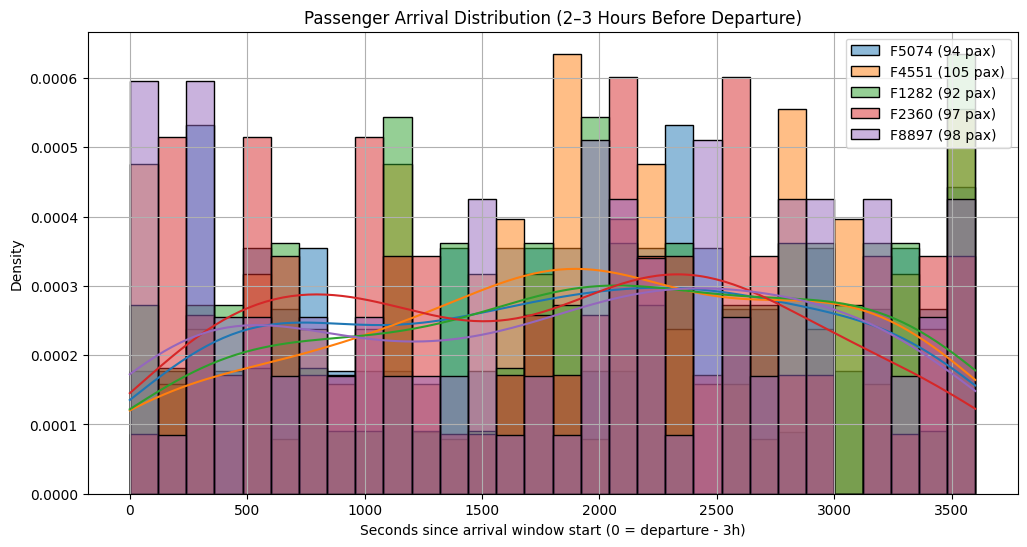

In [ ]:
plt.figure(figsize=(12, 6))

for flight in flights[45:50]:  # Plot only first few flights to keep it clean
    relative_arrivals = [t - (flight.departure_time - 3 * 3600) for t in flight.passenger_arrivals]
    sns.histplot(relative_arrivals, bins=30, kde=True, label=f"{flight.flight_no} ({flight.num_passengers} pax)", stat='density')

plt.title('Passenger Arrival Distribution (2–3 Hours Before Departure)')
plt.xlabel('Seconds since arrival window start (0 = departure - 3h)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

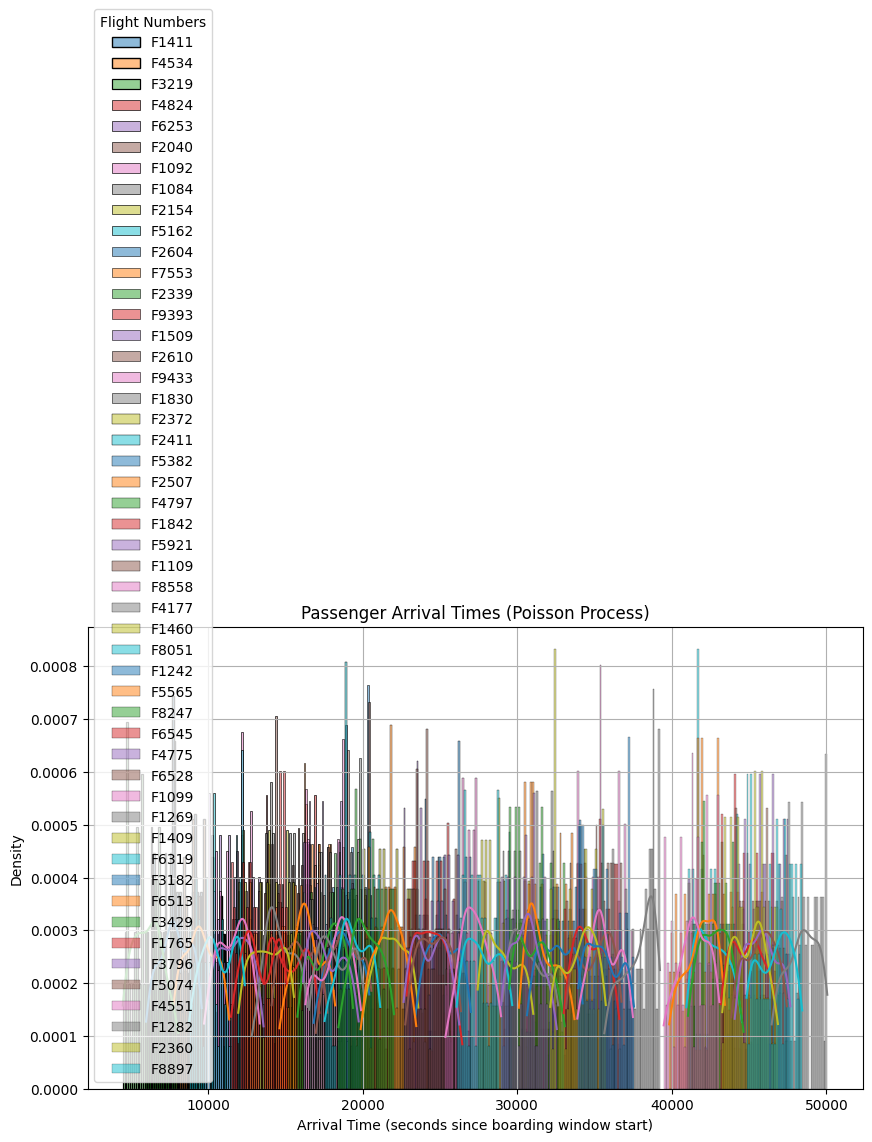

In [ ]:
# Visualization: Plot the arrival timelines for passengers in each flight
plt.figure(figsize=(10, 6))

# Plot arrival times for each flight
for flight in flights[0:50]:
    sns.histplot(flight.passenger_arrivals, kde=True, label=flight.flight_no, bins=30, stat='density')

plt.title('Passenger Arrival Times (Poisson Process)')
plt.xlabel('Arrival Time (seconds since boarding window start)')
plt.ylabel('Density')
plt.legend(title="Flight Numbers")
plt.grid(True)
plt.show()


1. Timeline graph for passengers

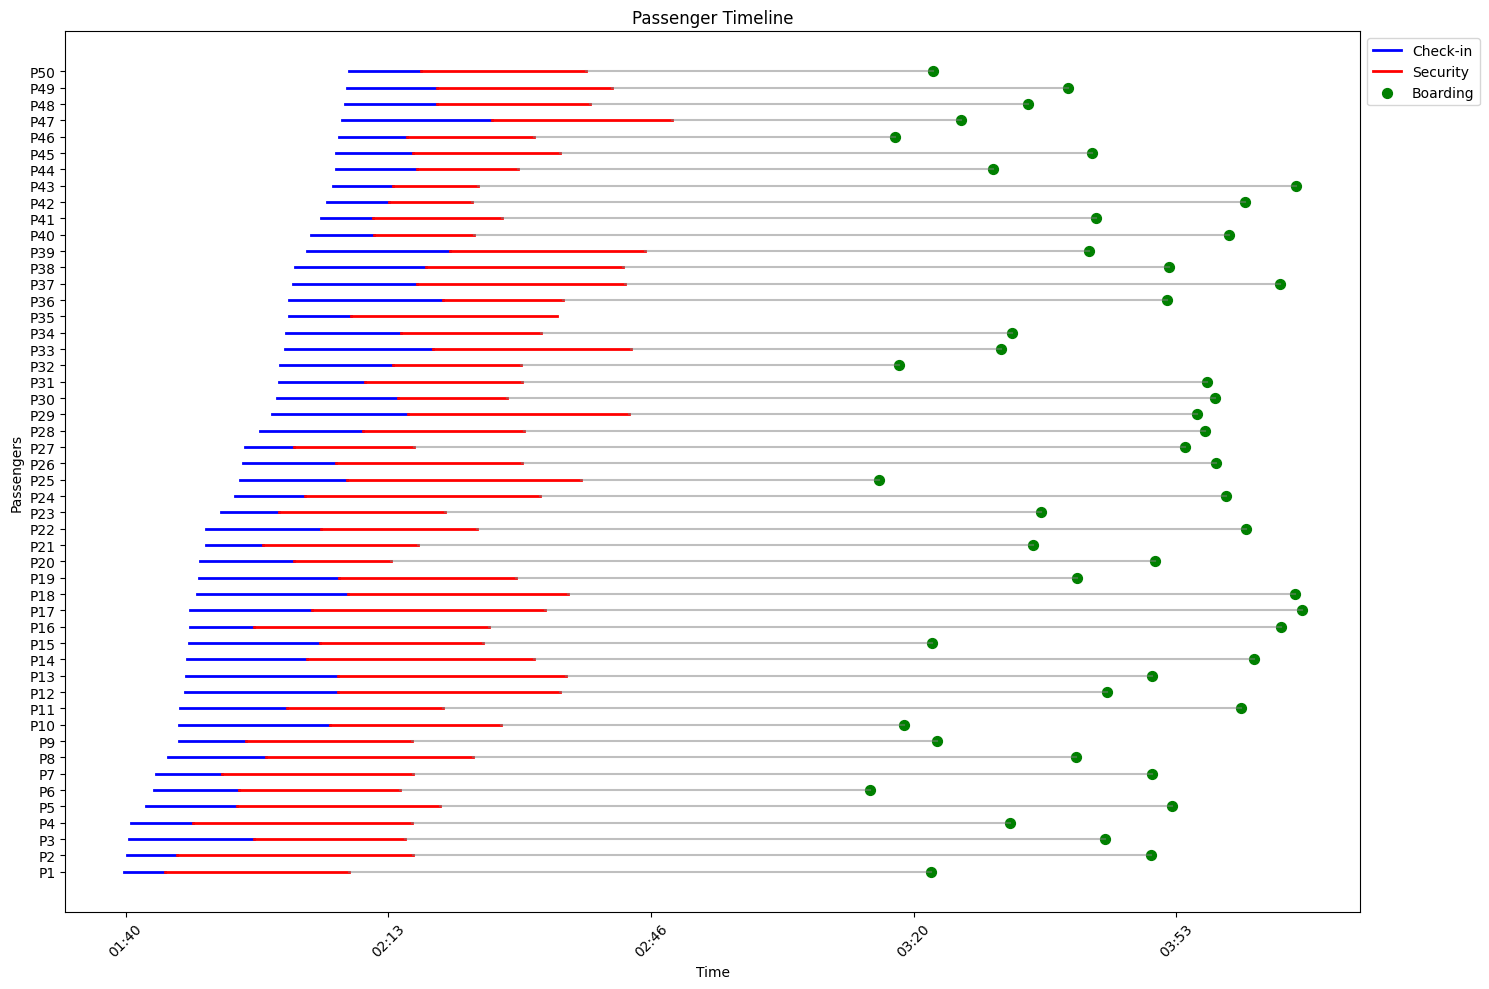

In [ ]:
def plot_passenger_timeline(passengers, num_passengers=50):
    fig, ax = plt.subplots(figsize=(15, 10))

    for i, passenger in enumerate(passengers[:num_passengers]):
        arrival = passenger.metadata['arrival_time']
        checkin_start = passenger.metadata['checkin']['checkin_time'][0]
        checkin_end = passenger.metadata['checkin']['checkin_time'][1]
        security_start = passenger.metadata['security']['security_queue_start']
        security_end = passenger.metadata['security']['security_queue_end']
        boarding = passenger.metadata['boarding'].get('boarded_at', None)

        ax.plot([arrival, checkin_start], [i, i], color='gray', alpha=0.5)
        ax.plot([checkin_start, checkin_end], [i, i], color='blue', linewidth=2, label='Check-in' if i == 0 else "")
        ax.plot([checkin_end, security_start], [i, i], color='gray', alpha=0.5)
        ax.plot([security_start, security_end], [i, i], color='red', linewidth=2, label='Security' if i == 0 else "")
        if boarding:
            ax.plot([security_end, boarding], [i, i], color='gray', alpha=0.5)
            ax.scatter(boarding, i, color='green', s=50, label='Boarding' if i == 0 else "")

    ax.set_yticks(range(num_passengers))
    ax.set_yticklabels([f"P{i+1}" for i in range(num_passengers)])
    ax.set_xlabel('Time')
    ax.set_ylabel('Passengers')
    ax.set_title('Passenger Timeline')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Format x-axis to show time
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: datetime.fromtimestamp(x).strftime('%H:%M')))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_passenger_timeline(passengers)

2. Gantt chart for flights

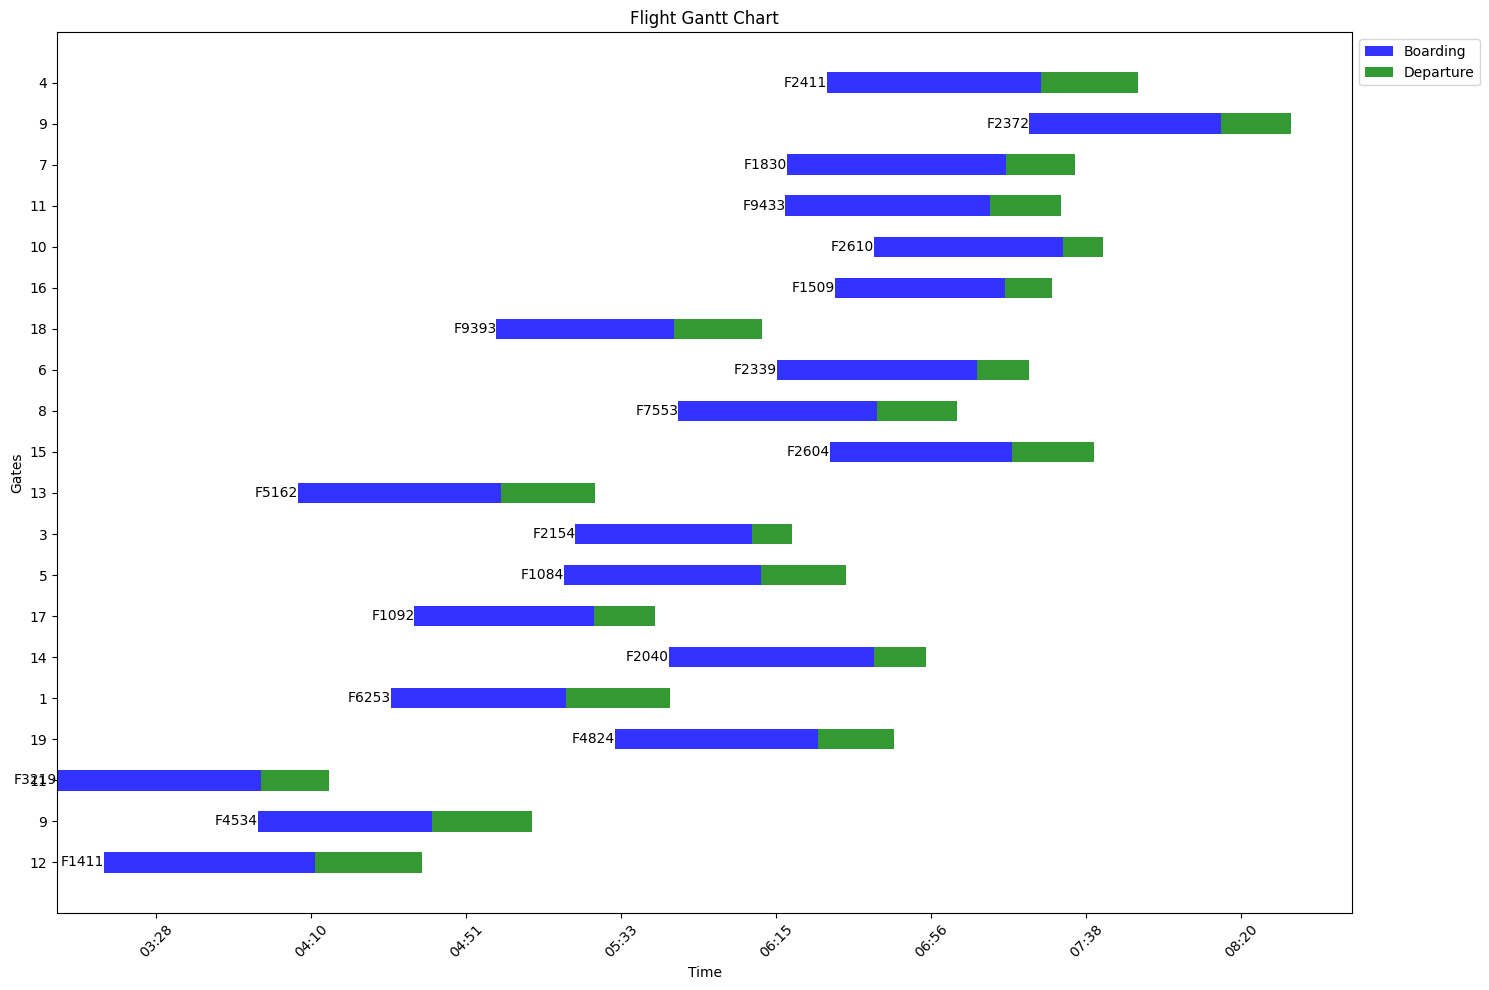

In [ ]:
def plot_flight_gantt(flights, num_flights=20):
    fig, ax = plt.subplots(figsize=(15, 10))

    for i, flight in enumerate(flights[:num_flights]):
        boarding_start = flight.boarding_time[0]
        boarding_end = flight.boarding_time[1]
        departure = flight.departure_time

        ax.barh(i, width=boarding_end-boarding_start, left=boarding_start, height=0.5, align='center', color='blue', alpha=0.8, label='Boarding' if i == 0 else "")
        ax.barh(i, width=departure-boarding_end, left=boarding_end, height=0.5, align='center', color='green', alpha=0.8, label='Departure' if i == 0 else "")

        ax.text(boarding_start, i, flight.flight_no, va='center', ha='right') # optional: fontweight='bold'

    ax.set_yticks(range(len(flights[:num_flights])))
    ax.set_yticklabels([f"{flight.gate_no}" for flight in flights[:num_flights]])
    ax.set_xlabel('Time')
    ax.set_ylabel('Gates')
    ax.set_title('Flight Gantt Chart')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Format x-axis to show time
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: datetime.fromtimestamp(x).strftime('%H:%M')))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_flight_gantt(flights)

3. Heatmap of passenger activity

<ipython-input-39-4541cf5aa5ab>:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index=['Activity'], columns='Hour', aggfunc='size', fill_value=0)


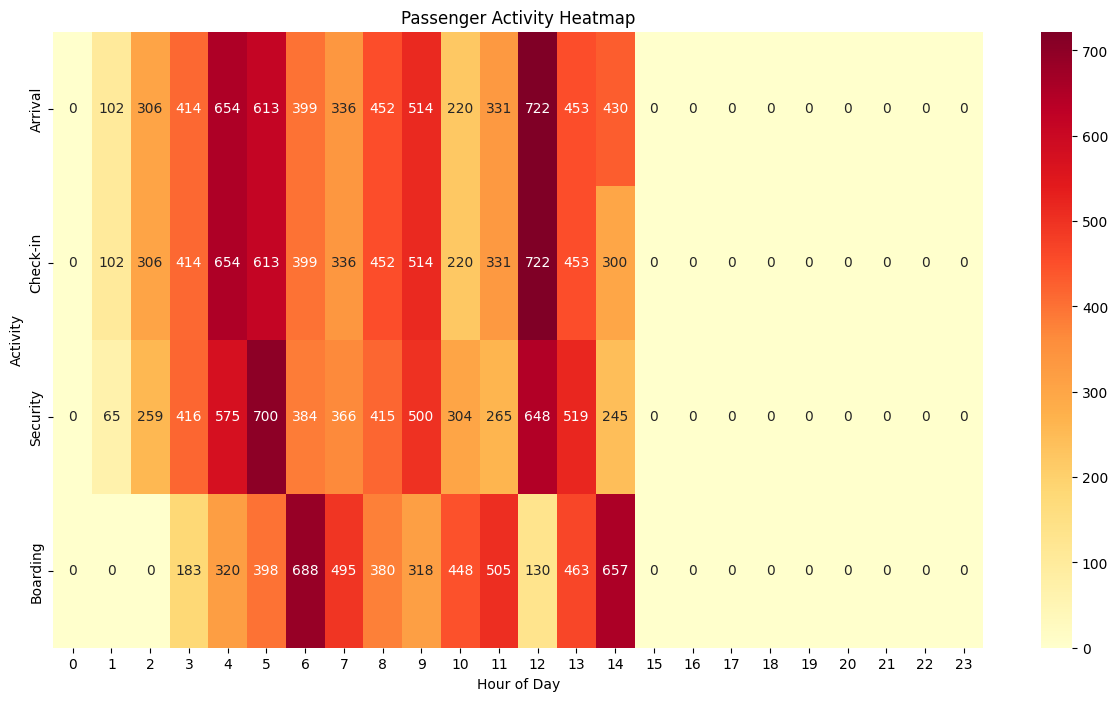

In [ ]:
def plot_passenger_heatmap(passengers):
    activities = []
    for passenger in passengers:
        # Arrival
        arrival_time = passenger.metadata['arrival_time']
        if arrival_time is not None:
            activities.append(('Arrival', datetime.fromtimestamp(arrival_time).hour))

        # Check-in
        if 'checkin' in passenger.metadata and 'checkin_time' in passenger.metadata['checkin']:
            activities.append(('Check-in', datetime.fromtimestamp(passenger.metadata['checkin']['checkin_time'][0]).hour))

        # Security
        if 'security' in passenger.metadata and 'security_queue_start' in passenger.metadata['security']:
            activities.append(('Security', datetime.fromtimestamp(passenger.metadata['security']['security_queue_start']).hour))

        # Boarding
        if 'boarding' in passenger.metadata and 'boarded_at' in passenger.metadata['boarding']:
            activities.append(('Boarding', datetime.fromtimestamp(passenger.metadata['boarding']['boarded_at']).hour))

    df = pd.DataFrame(activities, columns=['Activity', 'Hour'])
    # Ensure correct activity order
    activity_order = ['Arrival', 'Check-in', 'Security', 'Boarding']
    df['Activity'] = pd.Categorical(df['Activity'], categories=activity_order, ordered=True)

    # Create pivot table
    pivot = df.pivot_table(index=['Activity'], columns='Hour', aggfunc='size', fill_value=0)
    pivot = pivot.reindex(columns=range(24), fill_value=0)  # Ensure all hours are represented

    # Plot heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='d')
    plt.title('Passenger Activity Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Activity')
    plt.show()

# Call the function
plot_passenger_heatmap(passengers)

<ipython-input-40-da540db00011>:41: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index=['Activity', 'Day'], columns='Hour', aggfunc='size', fill_value=0)


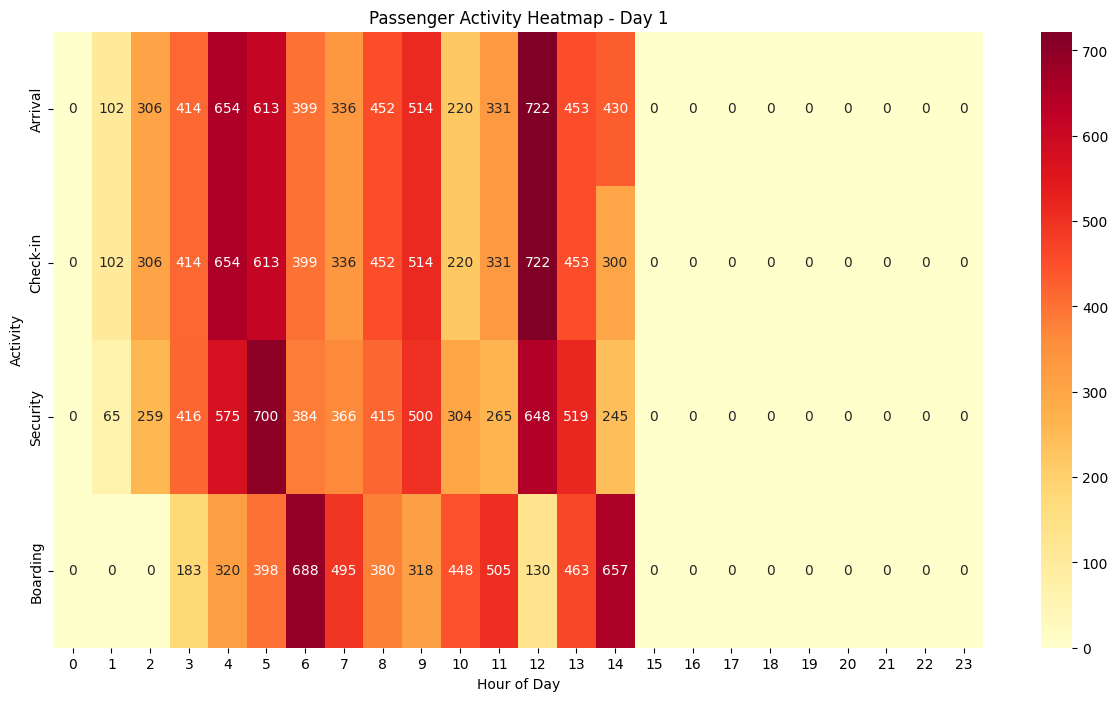

In [ ]:
def plot_passenger_heatmap(passengers, sim_start_time):
    activities = []
    sim_start = datetime.fromtimestamp(sim_start_time)

    for passenger in passengers:
        # Arrival
        arrival_time = passenger.metadata['arrival_time']
        if arrival_time is not None:
            day = (datetime.fromtimestamp(arrival_time) - sim_start).days
            hour = datetime.fromtimestamp(arrival_time).hour
            activities.append(('Arrival', day, hour))

        # Check-in
        if 'checkin' in passenger.metadata and 'checkin_time' in passenger.metadata['checkin']:
            checkin_time = passenger.metadata['checkin']['checkin_time'][0]
            day = (datetime.fromtimestamp(checkin_time) - sim_start).days
            hour = datetime.fromtimestamp(checkin_time).hour
            activities.append(('Check-in', day, hour))

        # Security
        if 'security' in passenger.metadata and 'security_queue_start' in passenger.metadata['security']:
            security_time = passenger.metadata['security']['security_queue_start']
            day = (datetime.fromtimestamp(security_time) - sim_start).days
            hour = datetime.fromtimestamp(security_time).hour
            activities.append(('Security', day, hour))

        # Boarding
        if 'boarding' in passenger.metadata and 'boarded_at' in passenger.metadata['boarding']:
            boarding_time = passenger.metadata['boarding']['boarded_at']
            day = (datetime.fromtimestamp(boarding_time) - sim_start).days
            hour = datetime.fromtimestamp(boarding_time).hour
            activities.append(('Boarding', day, hour))

    df = pd.DataFrame(activities, columns=['Activity', 'Day', 'Hour'])

    # Ensure correct activity order
    activity_order = ['Arrival', 'Check-in', 'Security', 'Boarding']
    df['Activity'] = pd.Categorical(df['Activity'], categories=activity_order, ordered=True)

    # Create pivot table
    pivot = df.pivot_table(index=['Activity', 'Day'], columns='Hour', aggfunc='size', fill_value=0)
    pivot = pivot.reindex(columns=range(24), fill_value=0)  # Ensure all hours are represented

    # Plot heatmap for each day
    num_days = df['Day'].nunique()
    for day in range(num_days):
        day_pivot = pivot.xs(day, level='Day')

        plt.figure(figsize=(15, 8))
        sns.heatmap(day_pivot, cmap='YlOrRd', annot=True, fmt='d')
        plt.title(f'Passenger Activity Heatmap - Day {day + 1}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Activity')
        plt.show()

# Call the function
plot_passenger_heatmap(passengers, env.now - SIM_TIME)  # Assuming env.now gives the end time of simulation

4. Cumulative Passenger Flow Bar Chart

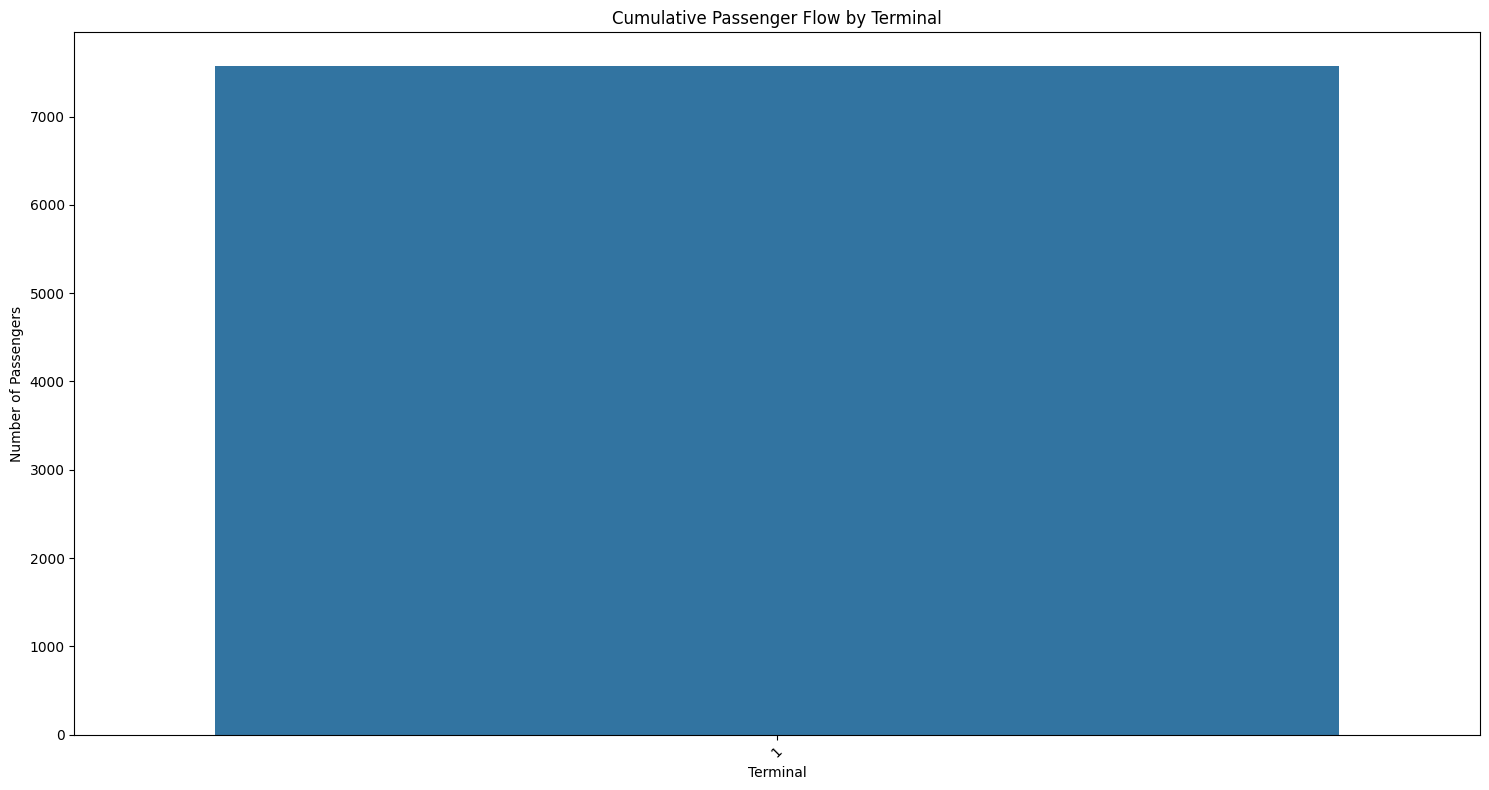

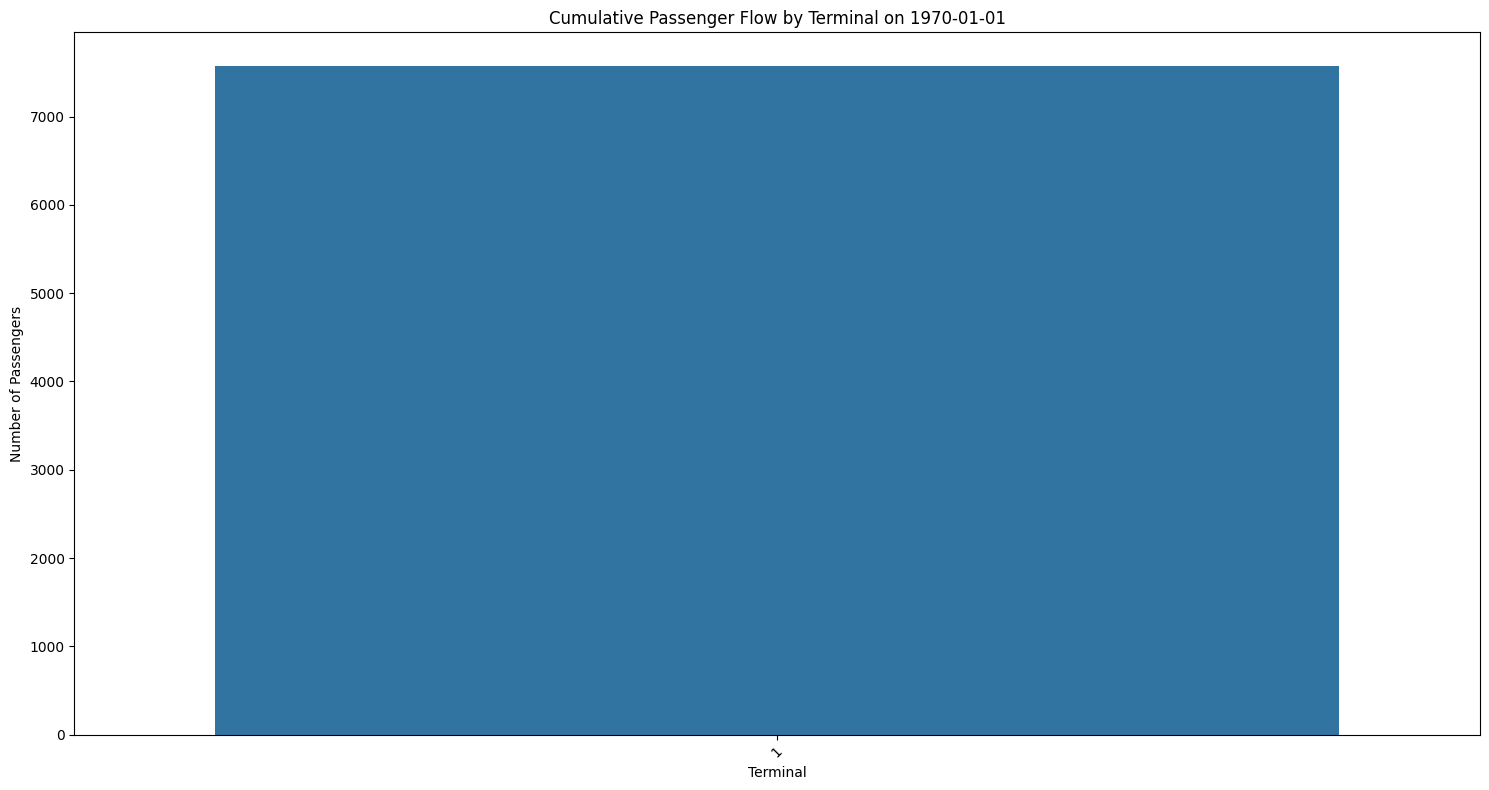

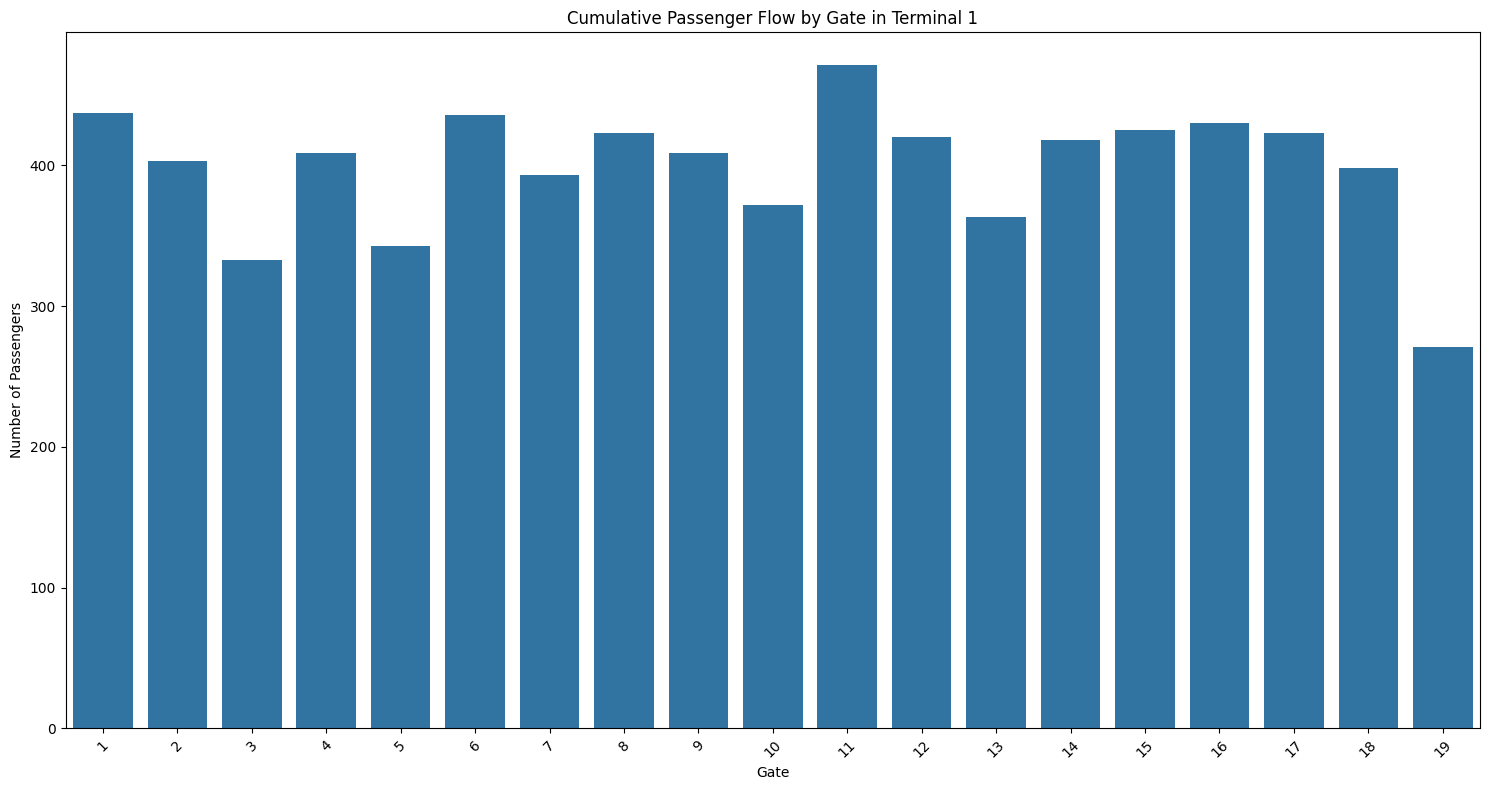

No data available for the specified date: 1970-01-02


In [ ]:
def plot_cumulative_passenger_flow(flights, specific_date=None, terminal_no=None):
    # Create DataFrame
    df = pd.DataFrame([(f.terminal_no, f.gate_no, f.num_passengers, f.boarding_time[0]) for f in flights],
                      columns=['Terminal', 'Gate', 'Passengers', 'Boarding Time'])

    # Convert boarding time to datetime
    df['Date'] = pd.to_datetime(df['Boarding Time'], unit='s').dt.date

    # Filter by date if specified
    if specific_date:
        try:
            specific_date = pd.to_datetime(specific_date).date()
            df = df[df['Date'] == specific_date]
            if df.empty:
                print(f"No data available for the specified date: {specific_date}")
                return
        except ValueError:
            print("Invalid date format. Please use 'YYYY-MM-DD'.")
            return

    # Filter by terminal if specified
    if terminal_no is not None:
        df = df[df['Terminal'] == terminal_no]
        if df.empty:
            print(f"No data available for Terminal {terminal_no}")
            return

    # Group by Terminal and Gate
    if terminal_no is not None:
        df = df.groupby('Gate')['Passengers'].sum().reset_index()
        title = f'Cumulative Passenger Flow by Gate in Terminal {terminal_no}'
        x_label = 'Gate'
    else:
        df = df.groupby('Terminal')['Passengers'].sum().reset_index()
        title = 'Cumulative Passenger Flow by Terminal'
        x_label = 'Terminal'

    # Sort by passenger count
    df = df.sort_values('Passengers', ascending=False)

    # Plot
    plt.figure(figsize=(15, 8))
    sns.barplot(x=x_label, y='Passengers', data=df)

    # Set title
    if specific_date:
        title += f" on {specific_date}"
    plt.title(title)

    plt.xlabel(x_label)
    plt.ylabel('Number of Passengers')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_cumulative_passenger_flow(flights)  # All data
plot_cumulative_passenger_flow(flights, specific_date='1970-01-01')  # Specific date
plot_cumulative_passenger_flow(flights, terminal_no=1)  # Specific terminal
plot_cumulative_passenger_flow(flights, specific_date='1970-01-02', terminal_no=1)  # Specific date and terminal


5. Security Wait Time Distribution

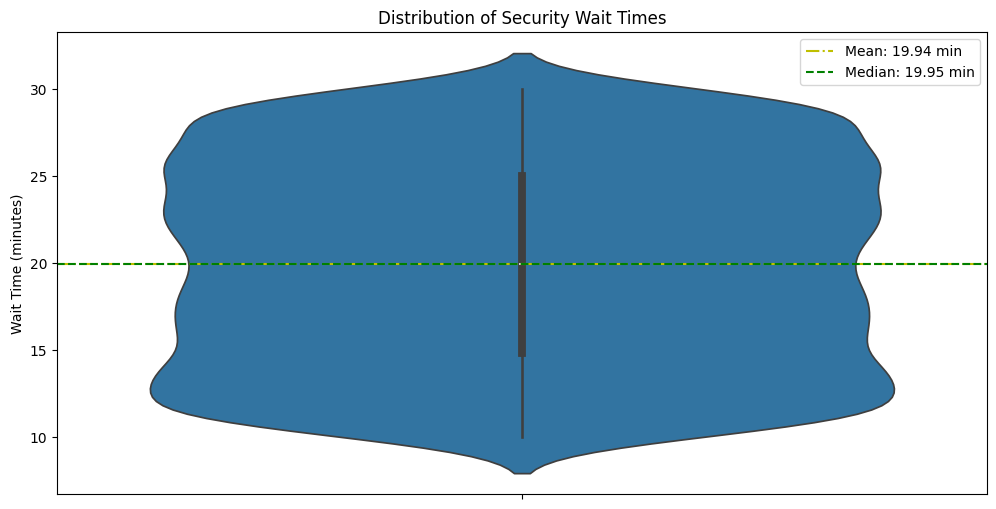

Number of passengers with valid security wait times: 5661
Minimum wait time: 10.00 minutes
Maximum wait time: 30.00 minutes


In [ ]:
def plot_security_wait_time(passengers):
    wait_times = []
    for p in passengers:
        security_data = p.metadata.get('security', {})
        end_time = security_data.get('security_queue_end')
        start_time = security_data.get('security_queue_start')

        if end_time is not None and start_time is not None:
            wait_time = (end_time - start_time) / 60  # Convert to minutes
            wait_times.append(wait_time)

    if not wait_times:
        print("No valid security wait times found in the data.")
        return

    plt.figure(figsize=(12, 6))
    sns.violinplot(y=wait_times)
    plt.title('Distribution of Security Wait Times')
    plt.ylabel('Wait Time (minutes)')

    # Add some statistical information
    avg_wait = np.mean(wait_times)
    median_wait = np.median(wait_times)
    plt.axhline(avg_wait, color='y', linestyle='-.', label=f'Mean: {avg_wait:.2f} min')
    plt.axhline(median_wait, color='g', linestyle='--', label=f'Median: {median_wait:.2f} min')

    plt.legend()
    plt.show()

    # Print additional statistics
    print(f"Number of passengers with valid security wait times: {len(wait_times)}")
    print(f"Minimum wait time: {min(wait_times):.2f} minutes")
    print(f"Maximum wait time: {max(wait_times):.2f} minutes")

plot_security_wait_time(passengers)

6. Check-in Method Distribution Pie Chart

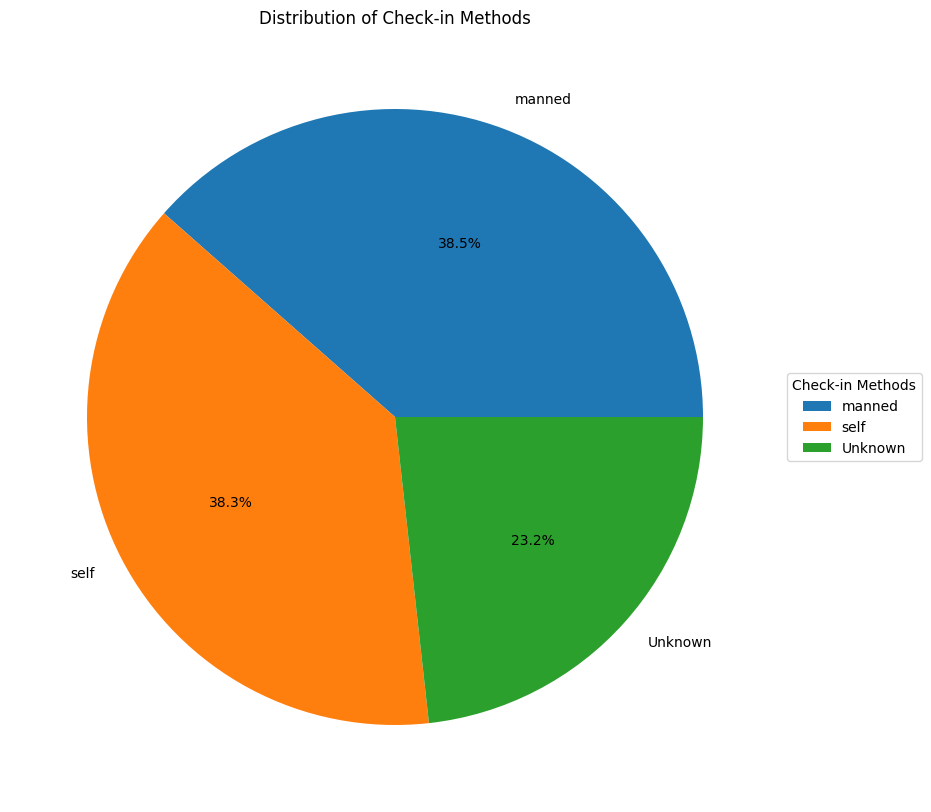

Check-in method counts:
manned: 2917
self: 2899
Unknown: 1761


In [ ]:
def plot_checkin_method_distribution(passengers):
    checkin_methods = []
    for p in passengers:
        checkin_data = p.metadata.get('checkin', {})
        checkin_type = checkin_data.get('checkin_type', 'Unknown')
        checkin_methods.append(checkin_type)

    method_counts = pd.Series(checkin_methods).value_counts()

    if method_counts.empty:
        print("No check-in method data found.")
        return

    plt.figure(figsize=(10, 10))
    plt.pie(method_counts, labels=method_counts.index, autopct='%1.1f%%')
    plt.title('Distribution of Check-in Methods')

    # Add a legend
    plt.legend(title="Check-in Methods", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.show()

    # Print the counts
    print("Check-in method counts:")
    for method, count in method_counts.items():
        print(f"{method}: {count}")

plot_checkin_method_distribution(passengers)

7. Gate Utilization Heatmap

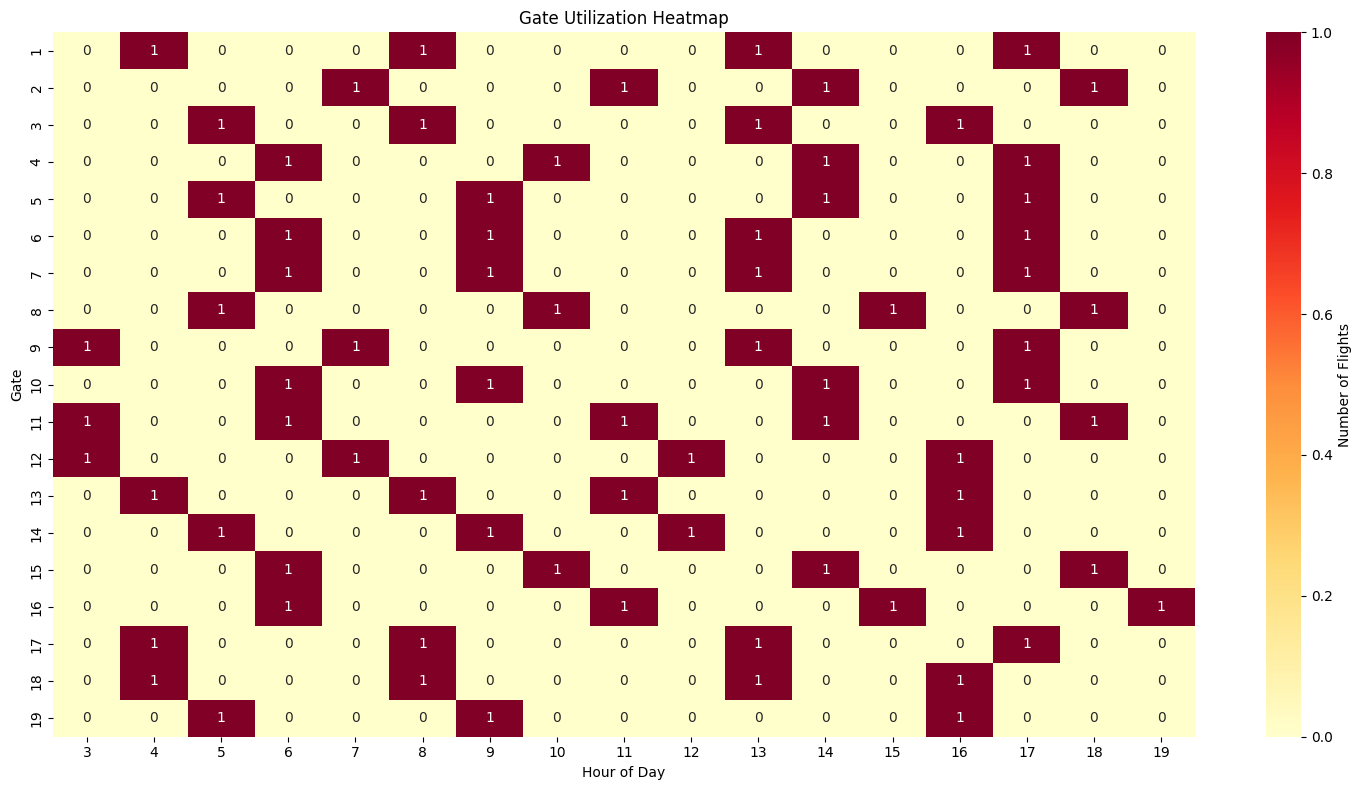

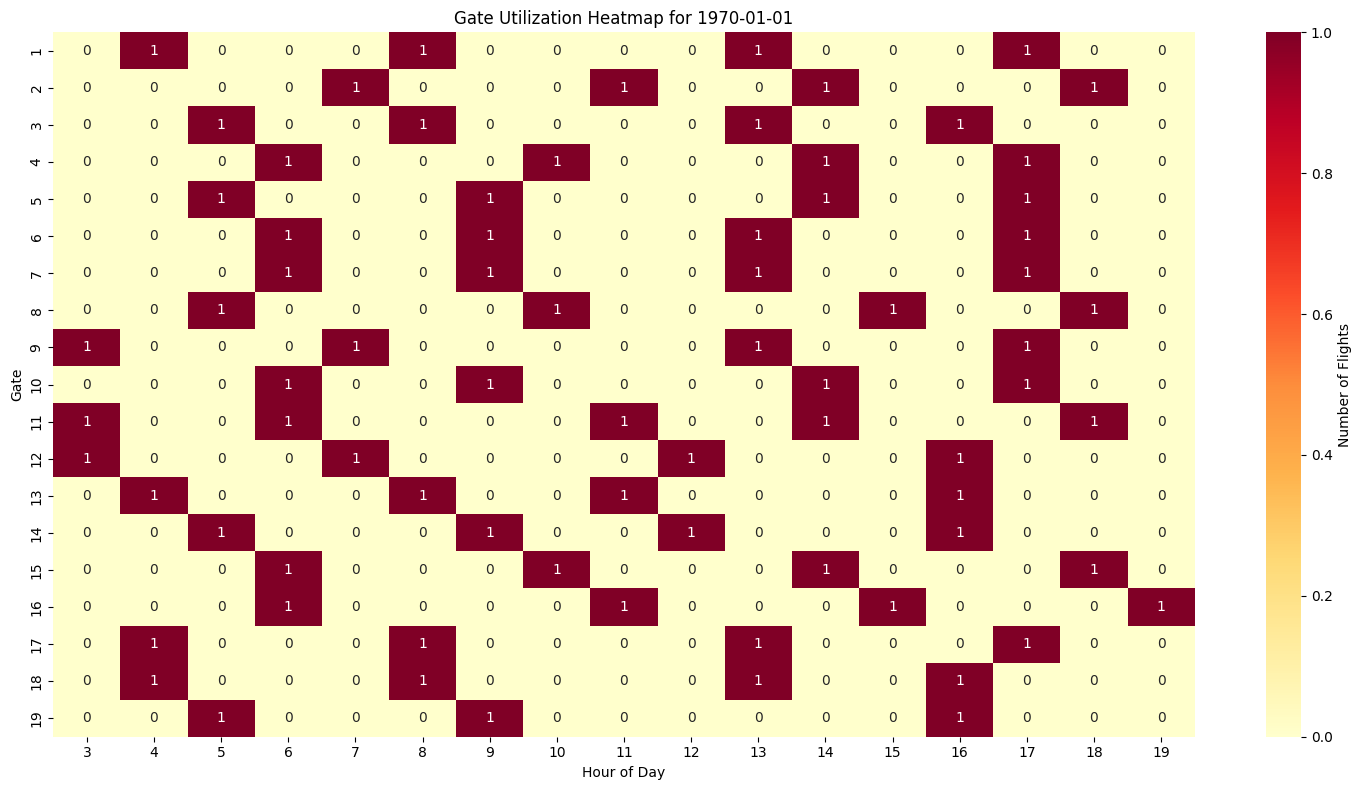

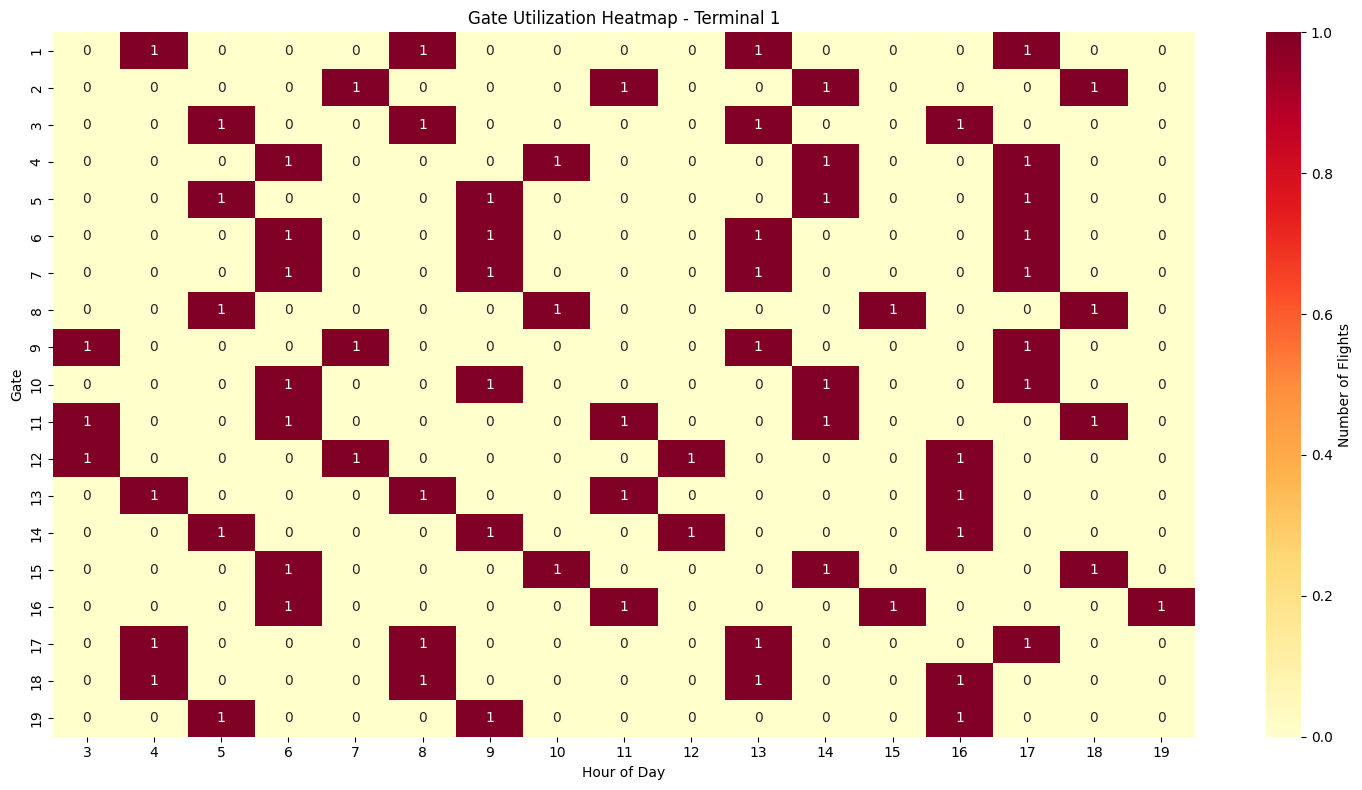

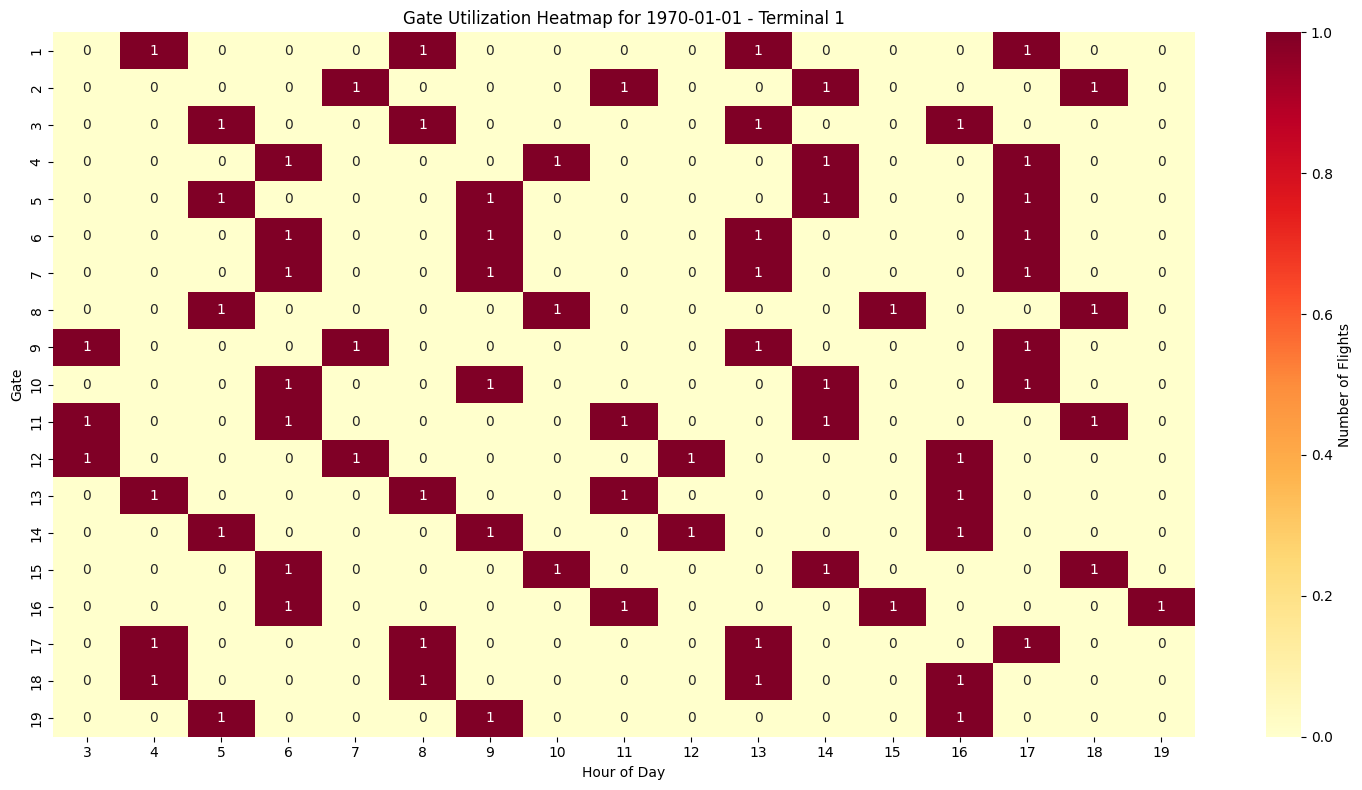

In [ ]:
def plot_gate_utilization(flights, specific_date=None, terminal_no=None):
    # Create DataFrame
    df = pd.DataFrame([(f.terminal_no, f.gate_no, f.boarding_time[0], f.departure_time) for f in flights],
                      columns=['Terminal', 'Gate', 'Boarding Start', 'Departure'])

    # Convert timestamps to datetime
    df['Boarding Start'] = pd.to_datetime(df['Boarding Start'], unit='s')
    df['Departure'] = pd.to_datetime(df['Departure'], unit='s')
    df['Date'] = df['Boarding Start'].dt.date
    df['Hour'] = df['Boarding Start'].dt.hour

    # Filter by date if specified
    if specific_date:
        try:
            specific_date = pd.to_datetime(specific_date).date()
            df = df[df['Date'] == specific_date]
            if df.empty:
                print(f"No data available for the specified date: {specific_date}")
                return
        except ValueError:
            print("Invalid date format. Please use 'YYYY-MM-DD'.")
            return

    # Filter by terminal if specified
    if terminal_no is not None:
        df = df[df['Terminal'] == terminal_no]
        if df.empty:
            print(f"No data available for Terminal {terminal_no}")
            return

    # Create pivot table
    pivot = df.pivot_table(index='Gate', columns='Hour', aggfunc='size', fill_value=0)

    # Sort gates numerically
    pivot = pivot.sort_index(key=lambda x: x.astype(int))

    # Plot
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Number of Flights'})

    # Set title
    title = 'Gate Utilization Heatmap'
    if specific_date:
        title += f" for {specific_date}"
    if terminal_no is not None:
        title += f" - Terminal {terminal_no}"
    plt.title(title)

    plt.xlabel('Hour of Day')
    plt.ylabel('Gate')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_gate_utilization(flights)  # All data
plot_gate_utilization(flights, specific_date='1970-01-01')  # Specific date
plot_gate_utilization(flights, terminal_no=1)  # Specific terminal
plot_gate_utilization(flights, specific_date='1970-01-01', terminal_no=1)  # Specific date and terminal

8. Real-Time Passenger Flow Forecast using LSTM

> Long short-term memory (LSTM) is a type of neural network that can learn and process sequential data over time.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-45-d1737af3b068>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_forecast[0, -1, 0] = forecast


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


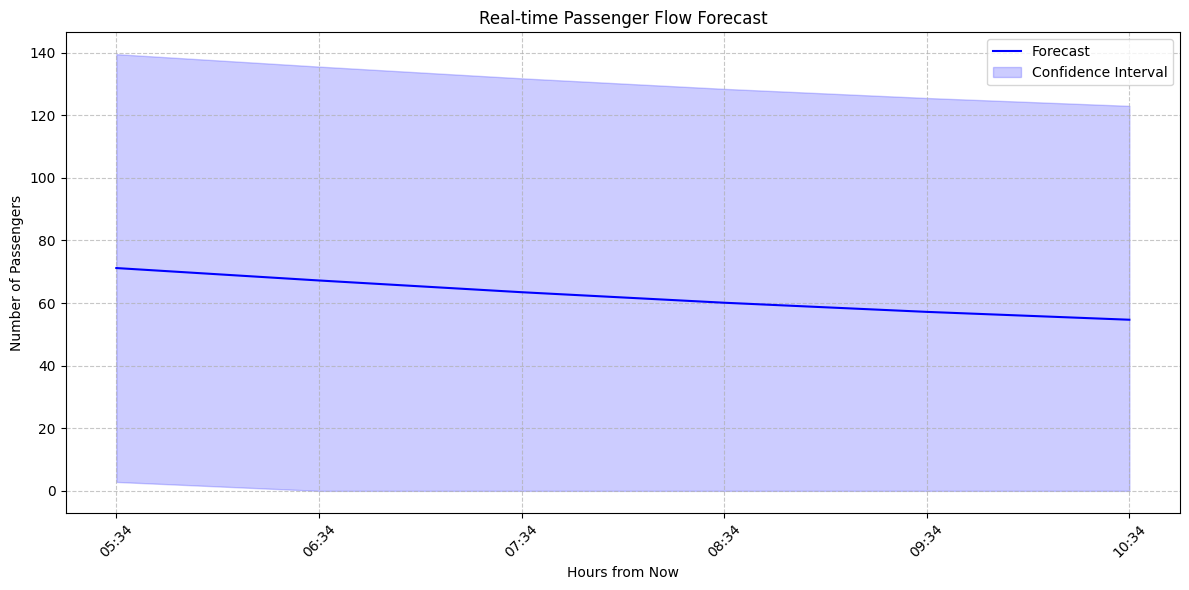

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

def train_lstm_model(data, time_step=1):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(data.reshape(-1, 1))

    # Create datasets for training
    X, y = create_dataset(data_normalized, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Train the model
    model.fit(X, y, batch_size=32, epochs=100, verbose=0)

    return model, scaler

def forecast_passenger_flow(model, scaler, last_known_data, forecast_hours=6):
    last_known_data = scaler.transform(last_known_data.reshape(-1, 1))
    X_forecast = last_known_data[-model.input_shape[1]:]
    X_forecast = X_forecast.reshape(1, -1, 1)

    forecasts = []
    for _ in range(forecast_hours):
        forecast = model.predict(X_forecast)
        forecasts.append(forecast[0, 0])
        X_forecast = np.roll(X_forecast, -1, axis=1)
        X_forecast[0, -1, 0] = forecast

    return scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

def plot_realtime_passenger_flow_forecast(current_time, historical_data, forecast_hours=6):
    # Train the LSTM model
    time_step = 24  # Use last 24 hours of data for each prediction
    model, scaler = train_lstm_model(historical_data, time_step)

    # Generate forecast
    last_known_data = historical_data[-time_step:]
    forecast = forecast_passenger_flow(model, scaler, last_known_data, forecast_hours)

    # Calculate confidence intervals (using standard deviation of historical data as a simple heuristic)
    std_dev = np.std(historical_data)
    confidence = np.full(forecast.shape, std_dev * 1.96)  # 95% confidence interval

    # Create the plot
    hours = np.arange(forecast_hours)
    plt.figure(figsize=(12, 6))
    plt.plot(hours, forecast, 'b-', label='Forecast')

    lower_bound = np.maximum(0, forecast.flatten() - confidence.flatten())
    upper_bound = forecast.flatten() + confidence.flatten()
    plt.fill_between(hours, lower_bound, upper_bound, alpha=0.2, color='b', label='Confidence Interval')

    # Customize the plot
    plt.title('Real-time Passenger Flow Forecast')
    plt.xlabel('Hours from Now')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis labels to show actual times
    time_labels = [(current_time + timedelta(hours=int(h))).strftime('%H:%M') for h in hours]
    plt.xticks(hours, time_labels, rotation=45)

    plt.tight_layout()
    plt.show()

# Usage example:
# Generate mock historical data (replace with your actual historical data)
historical_data = np.sin(np.arange(0, 10, 0.1)) * 50 + 100 + np.random.normal(0, 10, 100)
current_time = datetime.now()

plot_realtime_passenger_flow_forecast(current_time, historical_data)

### **Save Simulated Data**

In [ ]:
import csv

def safe_timestamp(metadata, *keys):
    for key in keys:
        if isinstance(metadata, dict):
            metadata = metadata.get(key, {})
        elif isinstance(metadata, list) and isinstance(key, int) and 0 <= key < len(metadata):
            metadata = metadata[key]
        else:
            return 'N/A'
    return datetime.fromtimestamp(metadata) if isinstance(metadata, (int, float)) else 'N/A'

def save_simulation_data(flights, passengers, flights_filename='flights_data.csv', passengers_filename='passengers_data.csv'):

    # Save flights data
    with open(flights_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Flight No', 'Terminal', 'Gate', 'Boarding Start', 'Boarding End', 'Departure', 'Num Passengers'])
        for flight in flights:
            writer.writerow([
                flight.flight_no,
                flight.terminal_no,
                flight.gate_no,
                datetime.fromtimestamp(flight.boarding_time[0]),
                datetime.fromtimestamp(flight.boarding_time[1]),
                datetime.fromtimestamp(flight.departure_time),
                flight.num_passengers
            ])

    print(f"Flights data saved to {flights_filename}")

    # Save passengers data
    with open(passengers_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Passenger ID', 'Flight No', 'Arrival Time', 'Check-in Type', 'Check-in Start', 'Check-in End',
                         'Security Queue Start', 'Security Queue End', 'Boarding Time'])
        for passenger in passengers:
            writer.writerow([
                passenger.passenger_id,
                passenger.flight.flight_no,
                safe_timestamp(passenger.metadata, 'arrival_time'),
                passenger.metadata.get('checkin', {}).get('checkin_type', 'N/A'),
                safe_timestamp(passenger.metadata, 'checkin', 'checkin_time', 0),
                safe_timestamp(passenger.metadata, 'checkin', 'checkin_time', 1),
                safe_timestamp(passenger.metadata, 'security', 'security_queue_start'),
                safe_timestamp(passenger.metadata, 'security', 'security_queue_end'),
                safe_timestamp(passenger.metadata, 'boarding', 'boarded_at')
            ])

    print(f"Passengers data saved to {passengers_filename}")

# Usage
save_simulation_data(flights, passengers)


Flights data saved to flights_data.csv
Passengers data saved to passengers_data.csv


In [ ]:
def print_flight_info(flightIdx):
  print("\nFlight Details:")
  print(f"Flight Number: {flights[flightIdx].flight_no}")
  print(f"Terminal: {flights[flightIdx].terminal_no}")
  print(f"Gate: {flights[flightIdx].gate_no}")
  print(f"Boarding Time: {datetime.fromtimestamp(flights[flightIdx].boarding_time[0])} - {datetime.fromtimestamp(flights[flightIdx].boarding_time[1])}")
  print(f"Departure Time: {datetime.fromtimestamp(flights[flightIdx].departure_time)}")
  print(f"Number of Passengers: {flights[flightIdx].num_passengers}")

def print_passenger_info(passengerNum, flightIdx):
  # Calculate the sum of passengers on previous flights
  sum_of_prev_flight_passengers = sum(flight.num_passengers for flight in flights[:flightIdx])

  # Calculate the actual passenger index
  actual_passenger_index = sum_of_prev_flight_passengers + passengerNum

  # Check if the calculated index is within the range of available passengers
  if (actual_passenger_index < len(passengers)) and (passengerNum <= flights[flightIdx].num_passengers):
    passenger = passengers[actual_passenger_index]
  else:
    print(f"Error: Passenger {actual_passenger_index} does not exist.")
    return

  flights[flightIdx].num_passengers

  print("\nPassenger Details:")
  print(f"Passenger ID: {passenger.passenger_id}")
  print(f"Flight Number: {passenger.flight.flight_no}")
  print(f"Arrival Time: {datetime.fromtimestamp(passenger.metadata['arrival_time'])}")
  print("Check-in Info:")
  print(f"  Type: {passenger.metadata['checkin']['checkin_type']}")
  print(f"  Time: {datetime.fromtimestamp(passenger.metadata['checkin']['checkin_time'][0])} - {datetime.fromtimestamp(passenger.metadata['checkin']['checkin_time'][1])}")
  if ('kiosk_id' in passenger.metadata['checkin']) and (passenger.metadata['checkin']['kiosk_id'] is not None):
      print(f"  Kiosk ID: {passenger.metadata['checkin']['kiosk_id']}")
  elif 'desk_id' in passenger.metadata['checkin']:
      print(f"  Desk ID: {passenger.metadata['checkin']['desk_id']}")
      print(f"  Checked Baggage: {passenger.metadata['checkin']['checked_baggage']}")
  print("Security Info:")
  print(f"  Queue Time: {datetime.fromtimestamp(passenger.metadata['security']['security_queue_start'])} - {datetime.fromtimestamp(passenger.metadata['security']['security_queue_end'])}")
  print(f"  Lane ID: {passenger.metadata['security']['lane_id']}")
  print(f"  Check Status: {passenger.metadata['security']['check_status']}")
  if 'boarded_at' in passenger.metadata['boarding']:
      print(f"Boarded At: {datetime.fromtimestamp(passenger.metadata['boarding']['boarded_at'])}")
  else:
      print("Not Boarded")

In [ ]:
# Print some results
print(f"Total flights: {len(flights)}")
print(f"Total passengers: {len(passengers)}")

# Print details for the flight
print_flight_info(flightIdx=0)

# Print details for the passenger
print_passenger_info(passengerNum=13, flightIdx=0)

# Print details for the passenger
print_passenger_info(passengerNum=14, flightIdx=0)

# Print details for the passenger
print_passenger_info(passengerNum=15, flightIdx=0)

# Print details for the passenger
print_passenger_info(passengerNum=16, flightIdx=0)

Total flights: 120
Total passengers: 15917

Flight Details:
Flight Number: F8950
Terminal: 1
Gate: 3
Boarding Time: 1970-01-01 03:01:53.919246 - 1970-01-01 03:49:52.919246
Departure Time: 1970-01-01 04:17:27.919246
Number of Passengers: 198

Passenger Details:
Passenger ID: Passenger 14
Flight Number: F8950
Arrival Time: 1970-01-01 00:09:32.919246
Check-in Info:
  Type: manned
  Time: 1970-01-01 00:09:32.919246 - 1970-01-01 00:24:49.919246
  Desk ID: 1
  Checked Baggage: 2
Security Info:
  Queue Time: 1970-01-01 00:24:49.919246 - 1970-01-01 00:47:14.919246
  Lane ID: 6
  Check Status: True
Boarded At: 1970-01-01 03:31:02.715144

Passenger Details:
Passenger ID: Passenger 15
Flight Number: F8950
Arrival Time: 1970-01-01 00:26:54.919246
Check-in Info:
  Type: self
  Time: 1970-01-01 00:26:54.919246 - 1970-01-01 00:32:06.919246
  Kiosk ID: 5
Security Info:
  Queue Time: 1970-01-01 00:32:06.919246 - 1970-01-01 00:56:10.919246
  Lane ID: 4
  Check Status: True
Boarded At: 1970-01-01 03:16:2

In [ ]:
import csv

def safe_timestamp(metadata, *keys):
    for key in keys:
        if isinstance(metadata, dict):
            metadata = metadata.get(key, {})
        elif isinstance(metadata, list) and isinstance(key, int) and 0 <= key < len(metadata):
            metadata = metadata[key]
        else:
            return 'N/A'
    return datetime.fromtimestamp(metadata) if isinstance(metadata, (int, float)) else 'N/A'

def save_simulation_data(flights, passengers, flights_filename='flights_data.csv', passengers_filename='passengers_data.csv'):

    # Save flights data
    with open(flights_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Flight No', 'Terminal', 'Gate', 'Boarding Start', 'Boarding End', 'Departure', 'Num Passengers'])
        for flight in flights:
            writer.writerow([
                flight.flight_no,
                flight.terminal_no,
                flight.gate_no,
                datetime.fromtimestamp(flight.boarding_time[0]),
                datetime.fromtimestamp(flight.boarding_time[1]),
                datetime.fromtimestamp(flight.departure_time),
                flight.num_passengers
            ])

    print(f"Flights data saved to {flights_filename}")

    # Save passengers data
    with open(passengers_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Passenger ID', 'Flight No', 'Arrival Time', 'Check-in Type', 'Check-in Start', 'Check-in End', 'Checked Baggage Count',
                         'Security Queue Start', 'Security Queue End', 'Security Lane', 'Check Status', 'Boarding Time'])
        for passenger in passengers:
            writer.writerow([
                passenger.passenger_id,
                passenger.flight.flight_no,
                safe_timestamp(passenger.metadata, 'arrival_time'),
                passenger.metadata.get('checkin', {}).get('checkin_type', 'N/A'),
                safe_timestamp(passenger.metadata, 'checkin', 'checkin_time', 0),
                safe_timestamp(passenger.metadata, 'checkin', 'checkin_time', 1),
                passenger.metadata.get('checkin', {}).get('checked_baggage', 0),
                safe_timestamp(passenger.metadata, 'security', 'security_queue_start'),
                safe_timestamp(passenger.metadata, 'security', 'security_queue_end'),
                passenger.metadata.get('security', {}).get('lane_id', 'N/A'),
                passenger.metadata.get('security', {}).get('check_status', 'N/A'),
                safe_timestamp(passenger.metadata, 'boarding', 'boarded_at')
            ])

    print(f"Passengers data saved to {passengers_filename}")

# Usage
save_simulation_data(flights, passengers)

Flights data saved to flights_data.csv
Passengers data saved to passengers_data.csv
